# Introduction

See the readme for a more "high level" orientation of the goals here.  In an immediate technical sense, we seek to build a binary classifier on a large textual data set, originating from reddit comments.  Our evaluation direct metric is recall for the target class, as a secondary evaluation standard we seek a model with with explainable and immediately sensible features, at least in aggregate. 

Some "high level", in the weakening sense of the term, discussion **is** provided in the concluding remarks. 

_____
______
# Contents
______
### 1) [Overview of Data Gathering and Processing](#heading1)
### 2) [Overview of Data Cleaning](#heading2)
### 3) [Model Creation](#heading3)
### 4) [Model Selection](#heading4)
### 5) [Model Evaluation](#heading5)
### 6) [Concluding Remarks](#heading6)

In [30]:
#Initial imports:
from ex_id_tools import data_processing,text_cleaning,modelling
import pickle
import numpy as np
import re
import pandas as pd
import seaborn as sns
sns.set_palette('husl')
sns.set_style('darkgrid')

<a id='heading1'></a>
_________________________________
# Overview of Data Gathering and Processing

Our data was gathered by direct export from a data set available through [pushhift.io's collection of reddit comments](https://files.pushshift.io/reddit/comments/).  The data unfortunately came "raw", with no strong attempt to avoid conflit with any potential .csv separators, and so much attention had to be paid to cleaning throughout the process. Two month's of data were used, representing all reddit comments from August and September of 2017. August of 2017 contained 84,658,503 posts; September contained 83,165,192.  The use of two months was due to an external constraint; namely to make the data processing be even remotely feasible.  The months chosen were semi-arbitrary, they fulfilled two criteria of not being obviously "special" with respect to political activity (somewhat removed in time from the previous election, not obviously around any major political stories relative to what's possible, etc) and being far enough back in time that it was possible to have some semblence of removednesses from current ongoings in order to try to assess media spotlighting of specific communities. As mentioned earlier, the files are quite large, both between 7-8 GB in their compressed form.  As such, they are not provided in this repo; rather if one wishes to reproduce this work these files should be obtained from the link given above.  


Note that "post" here is being used in the conventional sense, interchangeable with "comment".  It is not uncommon within reddit to treat "posts" as the initial comment or item beginning a thread and all subsequent replies along that thread as "comments".  The comments here represent both of these.  

Each month's data was formatted, in the original compressed .bz2 file, such that a single line would correspond to a single reddit post containing the following features:

|Entry|Explanation|
|--:|:--|
|body|The post contents, exactly as made (more on this below).|
|score hidden|Deprecated (null).|
|archived|Deprecated (null).|
|author|The username of the comment's creator.|
|author_flair_text|A short string associated with a specific user within a specific subreddit.|
|downs|Deprecated (null).|
|created_utc|Time the post was authored|
|subreddit_id|Code identifying subreddit (subforum/community) the post was made to.|
|link_id|Contradictory explanations, perhaps changing over time.  Seemingly represents a link to the specific post. Unused.|
|parent_id|Identifies original post in a given thread.|
|score|The rating given to the post by other users.|
|retreived_on|The time the post was archived (presumably, unclear).|
|controversiality|Possibly deprecated, possibly still functioning as a flag to indicate a post received both many positive and negative ratings.  Unused.|
|gilded|Indicates that a post resulted in another user gifting the author with "reddit gold", access to premium reddit features for a given period of time.|
|id|Identifies the post.|
|subreddit|The community/subforum the post was made to.|
|ups|Deprecated (null).|
|distinguished|Deprecated (null).|
|author_flair_css_class|Represents a decorator a post author might have associated with their account on a given subreddit.|

Of these featueres, the fields initially chosen to preserve during decompression were 'body', 'id', 'author', 'created_utc','subreddit','retrieved_on',and 'parent_id'.  Ultimately only 'subreddit' and 'body' were used for analysis. 

Mindful of memory constraints, the basic plan for the files was then:
1. Open the .bz2 file to read line-by-line
2. Initialize "files written" counter and a "lines written" counter. 
3. Open a .csv file to write to, appending to its name the current value for the "files written" counter.  
4. Read a line from the .bz2 file.  If it passes the filtering criteria, explained below, write it to the open .csv file and increment the "lines written" counter by one.  
5. If the number of lines written has surpassed a pre-set size, chosen (perhaps too cautiously) as 1,000,000, close the .csv file, increment the "files written" counter by 1, and start writing to a new .csv file with that counter's value as the new ending of its name. 
6. Continue until the .bz2 file is empty.

This functionality is provided in the `dataprocessing` subpackage of the `ex_id_tools` package included in this repo, should one wish to use it directly, under the module name `unpack_zipped`.  It should work with at least the files written *up to* these ones, though it's not impossible that something will go wrong for files written later. 

There are two things to note here: 
1. To save time and memory, some lines were automatically filtered out, based on initial exploration of samples of the data.  This consisted of "users" that were in actuality bots providing some site-wide helpful function, as well as posts that had been deleted prior to being harvested into the original dataset.  
2. The comments were transcribed directly into the original data set. As such, every csv separator that *could* come up *did* come up; keep in mind for instance there are conceivably comments made in reddit of people giving examples of csv files with different separators.  A choice was made that seemed to minimize errors and the fieldnames were specified ahead of time to try to mitigate this, but the data comes in extremely messy regardless and problematic entries do exist, which must later be handled.  

We'll shortly see this data being put into a sql database for further manipulation; if resources allow, note this same data is available on [Google's BigQuery service](https://console.cloud.google.com/bigquery?project=first-mark-284422&redirect_from_classic=true&p=fh-bigquery&d=reddit_comments&page=dataset), though an interested party should note that size of the tables means that even modest queries will require significant data usage.




These csvs were then explored a bit to get a feel for what would be feasible.  It was determined that as part of this work time and resource constraints would restrict analysis to simply subreddit and body information; while the other details provided in these files is useful and will be fruitful for further analysis, we will now move to extracting only the desired information.  

To create the data used in the next cell executions, please download the data explained above and run, with the filenames `file1.bz2` and `file2.bz2` swapped out for your file names (as well as schanging the target file names if desired), the following cell:

In [4]:
data_processing.unpack_zipped('file1.bz2','file1_unzipped_stem')
data_processing.unpack_zipped('file2.bz2','file1_unzipped_stem')

Resource limitations on both the ability to read files in and out of storage and to process large amounts of data in-core guided further data gathering.  For easy of reading through data not held in RAM, the locally downloaded datasets were read into a sql .db file.   Doing so is very simple with the .csv's obtained a moment ago, we simply loop panda's `to_sql` method over the list of files.  The `data_processing` subpackage gives this capability in the form of the `database_create` method, and can be run here:

In [5]:
data_processing.database_create('reddit_comments.db', #You may wish to change this name
                source_files #Put your list of files here
                ,make_new_table=True) #You will be prompted to confirm you wish to make a new table

With the data now in a sql table, the target class data was gathered by crawling through our list for members of our target communities, which were identified through researching controversial reddit communities within the site's internal news, searches through broad media coverage such as vantiy fair or the washington post, wikipedia's of "controversial reddit communities", and the southern poverty law center's coverage.  Those communities are stored in the data_sets folder as `working_list.p`

In [5]:
with open(r'data_sets\working_list.p','rb') as file:
    working_list=pickle.load(file)

We can then generate a  generally useful thing to have, a list of subreddit frequency, by counting these from our SQL table.  This capability is given in the data_processing package, and can be done by executing the cell below:

In [ ]:
sub_counts=data_processing.count_subreddits('reddit_comments.db')

This is also given by the sub_counts.p file in the data_sets folder.

In [3]:
with open(r'data_sets\sub_counts.p','rb') as file:
    sub_counts=pickle.load(file)

This allows us to visualize some basic properties of the data, for instance what's shown below ![example_image](graphics\size_distribution_readme.png) .

Target (extreme) subreddits were then generated by looping through the database to gather all such posts, then grouping the resulting dataframe by subreddit and appending the desired post collections to a dataframe, which is then written to a csv:

In [ ]:
for c in working_list:
    #proceed by subreddit
    df=pd.read_sql(f'''
    SELECT * FROM POSTS WHERE UPPER(subreddit) = "{c}"
    ''', conn,['subreddit','body']
                   )
    #get all needed posts
    df.reset_index(inplace=True)
    df=df[['body','subreddit']]
    df.dropna(inplace=True)    
    #We drop poor entries as we read
    df=pd.DataFrame((df.groupby(df.index // 100).body.sum()).iloc[:-1])
    #regroup by into sets of 100
    df['subreddit']=f'{c}'.upper()
    #format the subreddit name
    df.to_csv('class1_df.csv',mode='a',index=False,header=None)
    #write the result -- note the use of append here. 

The training data is then gathered by using the previously-found subbreddit frequencies to assign candidates to gather.  We create a list from this by choosing from the list of subreddits with replacement, weighting appropriately.  We then crawl through our sql database, grabbing sets of a hundred at random with the knowledge of how many sets of a hundred there are to grab from, per subreddit, again by referencing our sub_counts list. 

This is a bit involved, so we break it into two cells below and show the midway result of the first chunk, where the subreddits we'll look for and the groups of a hundred we'll gather are given below.

In [6]:
useable={k:v for k,v in sub_counts.items() if v>=100}
#get a dictionary containing only those subreddits large enough to qualify for further collection

weighting=sum(list(v for k,v in useable.items() if k not in working_list))
#Count total number of posts by sub 

useable_weights={k:v/weighting for k,v in useable.items() if k not in working_list}
#Get the normalized non-extreme weights

using_size=sum([sub_counts[k]//100 for k in working_list])
#Going for a 50/50 split initially -- this is a known bad idea-- and so just passing the number of 100s groupings.  
#The size should be adjusted to be as large as memory and time allows for. 

random_selector=np.random.default_rng(seed=98)
#set up rng
using_subs=random_selector.choice(list(useable_weights.keys()),size=using_size,p=list(useable_weights.values()))
#Pick the subs randomly
using_subs=np.unique(using_subs,return_counts=True)
#Turn them into counted objects, for use below
using_subs={sub:int(count) for sub,count in np.array(using_subs).T}
#Turn this into a dict, which ends up being a little redundant but helps at least *me* to get my head around what's 
#happening

indexing_dict={k:random_selector.choice(range(sub_counts[k]//100),size=v
                                       ) for k,v in using_subs.items()}
#This is definitely not as succinct as it could be, but is much more readable as a result.  Note range's exclusion behavior
#will have the effect of dropping the last option for our grabbing placement, which is good because we don't want that.

display([(k,v) for k,v in list(indexing_dict.items())[:5]])
#Print the first five items, to show what's going on, while resenting the way python handles dictionaries

[('1200ISJERKY', array([0])),
 ('1200ISPLENTY', array([  2,  24, 129, 145])),
 ('18_19', array([6])),
 ('2007SCAPE',
  array([ 687,   65, 1040,  463, 2661, 2399,  559,  102, 2498, 1965, 2726,
         1105, 2823, 2080, 1978, 1098, 1064, 1525,  210, 2194,  654, 2727,
         1183, 1886, 2096,  855, 1691, 1736, 3182,  274,  976, 2705, 1746,
         1776,  260, 1324, 2360, 1962, 1921,  772, 1973,  778, 2990, 3057,
         2891,   11, 1271, 2614, 2236, 2545,    2, 1940,  888, 1253, 3019,
         1912, 2110,  871, 1180])),
 ('23ANDME', array([13]))]

We now crawl again though our sql database.  This is a slow process no matter what we do, but by being a bit clever and being willing to be a bit opaque in our code we can speed up the process a little.  With the array of locations above, we crawl through our sql dataframe for each subreddit a little at a time, recording those chunks of 100 that are in our list of chunks to grab, and stopping when we've hit the last one we need to get to.  By doing this we can avoid the much more costly ".fetchall()" being given to sqlite3.  

<font color='gray'>*NB: This notebook is reporting what was done, not what one should do. Such a process will still be quite slow on an entirely local, consumer-level computer system, if done in SQL, but will be much less convoluted.  The hope here was that there would be some speed advantage by doing this with python, however this does not seem to be the case.  Further work would include collecting more data with an appropriate sql query.*</font>

In [ ]:
#just pulling out anything not alphanumeric or part of the desired formatting form
subber=re.compile(r'[\w_/]+')

for subreddit in indexing_dict.keys():
    temp_df=pd.DataFrame(columns=['body','subreddit'])
    c.execute(f'''
    SELECT subreddit,body FROM POSTS WHERE UPPER(subreddit) = "{sub}" 
    ''')
    n=0
    #Begin crawling through
    while n<=indexing_dict[sub].max():
        #Max so we only check as far as we need to
        grab=c.fetchmany(100)
        #pull up 100 posts
        if n in indexing_dict[sub]:
            #see if this is one of our numbers, if so record it
            temp_df=temp_df.append({'subreddit':subreddit, 'body':subber.sub(' ',' '.join([
                str(entry[1]) for entry in grab
            ]))},ignore_index=True)        
        n+=1
        #Writing to csv as we go because in case something goes awry midway though so that we don't need to lose work 
    temp_df.to_csv('class0_sym_data.csv',mode='a',header=False)

We can then concatenate our two dataframes into a single one, which we'll call "crude_training_data.csv" and assign the appropriate labels:

In [ ]:
df0=pd.read_csv('class0_sym_data.csv',header=None,names=['snapshot','subreddit','label'])
df0['label']=0
df1=pd.read_csv('class1_df.csv',header=None,names=['snapshot','subreddit','label'])
df1['label']=1
df_full=df0.append(df1,ignore_index=True)
df_full.to_csv(r'data_sets\crude_training_data.csv',header=None,names=['snapshot','subreddit','label'])

# Overview of Data Cleaning<a id='heading2'></a>

Here, we go through the work done for our data cleaning.  This is being done on the data that was actually used, with exteme emperical oversampling of the target class.  Aside from insights originating from direct sporadic observation of the data, however, the procedures are in principle blind to the overall picture of the data and could be applied to other reddit comments used to supplement this data.

The procedures done here are also located in the `text_cleaning` subpackage of the `ex_id`, along with a table of the regex expressions used and their intent.  Our goal here is to normalize our text for both the purpose of analysis but also to make using a larger sample more tractable for global learning and analysis on a single machine.  The resulting file, used for model training, is already located under the `data_sets` directory, this notebook shows how it is created but does not *need* to be ran for the other notebooks to work. 

We begin by importing the "crude working data" created in the <a id='heading1'>data harvesting</a> step above.

In [ ]:
working_data=pd.read_csv(r'data_sets\crude_data.csv',names=['snapshot','subreddit','label'],header=None)

We first take everything to lowercase and then try to drop anything problematic.  There are two types of meaningful tokens we want to be aware of besides works: the first, website urls-- we want to preserve this information the best that we can, at least initially (consider that choosing to drop websites will be as hard to do evenly across the board as finding a way to condense them).  The second is internal reddit username and subforum links, which are written as /u/user_name or /r/subreddit_name.  Nominally the links should begin with a /, though investigation shows that often is not the case.  The name itself can consist of a sequence of letters, numbers, or underscores.  We'd like to preserve this structure (we don't want to confuse "/r/politics", a political board on reddit, with the normal term "politics" for instance).  We'll write further text processing with this in mind, for now though we'll pass a regex substitution to normalize the expressions:

We will match anything of the form /u/valid_name_format or /r/valid_name_format and drop the leading /. These features, which are advisable to complete prior to the next step, can be accessed independently by the `basic_reddit_preformatting` method of `ex_id_tools.text_cleaning`

In [ ]:
working_data['snapshot']=working_data['snapshot'].str.lower()
#send all words to lowercase
working_data['snapshot']=working_data.snapshot.str.replace('(?<![^\s])/(?=\w/[\w]+)',' ')
#clean /x/yz-type strings

We then filter out non-english subforums; nominally part of data cleaning but not viable in an advisable way before basic text cleaning.  This is was done by identifying the ratio of non-english stopwords to english stopwords in each entry, then sorting the data by that ratio to try to find subreddits that may not be english-based.  This is a quite crude method, but allows for computational feasibility that more sophisticated means (using a pretrained classifier, presumably, or using a larger lexicon) would lack. 

The functionality is given in the `text_cleaning` submodule, under the name `crude_language_detect_toll`.  This series is used to define a sorted dataframe, then repeated slices can be displayed to find non-english subreddits.  The list of those found for this data set is saved as `foreign_sub_list.p` in the `data_sets` folder. 

In [ ]:
foreign_list=pickle.load(open(r'..\data_sets\foreign_sub_list.p','rb'))
working_data.drop(working_data[working_data['subreddit'].isin(foreign_list)].index,inplace=True)

In [ ]:
reddit_tokenizer=RegexpTokenizer(r'http[s]*[:]*[\w_/]+|www[\w/_]+|[ur]/[\w]+|[a-z]{2,}')

working_data['snapshot']=working_data['snapshot'].map(reddit_tokenizer.tokenize)
working_data['snapshot']=working_data['snapshot'].map(lambda l: [s for s in l if s not in stopwords])

At this point, initial modelling was attempted.  The results stimulated further cleaning, which is then done below.  First, we do take out the websites we previously had chosen to keep.  Note that in the filtering & tokenizing we're running the risk of losing some information, particularly non-english top-level domains (co.uk, now as co uk, begins to float around, for instance).  This helps motivate aggressive feature dropping later on-- already likely a good idea-- to try to suppress the effects of both the already existing noise and the incidental noise we introduce in trying to better isolate good features.  

We should be aware at this point we are going to lose some messages written in a not-unpopular fromat <font color='blue'>O F T Y P I N G L I K E T H I S</font>

We then attempt to collapse down repetitions, as users will often type "hahahahahahahahahahahaha, hahahahahahahaha", etc and those should likely be treated as the same.  Having handled this, we can then safely drop words that are of length greater than 45, which were read in incorrectly at some point or are otherwise unwanted, such as long internal/diagnostic text or websites.  Note this choice is for the purposes of computability and expedience; a preferable method in the absence of those would involve at least some information recovery from those strings with readily exploitable opportunities to be split.

In [ ]:
working_data['snapshot']=(working_data['snapshot']).map(lambda s:
                        [word for word in s if not re.match('http[s]*[:]*[\w_/]+|www[\w/_]+',word)])
#"url_start" in .text_cleaning.regex_store
working_data['snapshot']=working_data['snapshot'].map(    
        lambda s: list(
            map(
            (lambda w: re.sub(r'(\w{1,3}\w{0,3})\1{3,}','\g<1>\g<1>',w))
            ,s)))
#"repetitions_in and reptitions_out" in .text_cleaning.regex_store.  This will consense 1-and-2 letter repetitions

working_data['snapshot']=working_data['snapshot'].apply(lambda r: [w for w in r if len(w)<=45])
#Drop long strings

We then join our strings back together and resume further filtering, again informed by the results of intermediate models, on the data remaining.  First, we'll handle the abundant formatting characters like 'nbsp' that appear.  
We'll use the list of character entity reference from:https://www.w3schools.com/html/html_entities.asp .  For ease we'll rejoin the snapshot column before working. In dropping these we take special care with respect to the details of the english language, a word ending with "nbsp' probably just has that on as a mistake, but a word ending with "amp" is likely just a normal english word.  An opportunity exists here for further filtering by examining the distribution of, say, words ending in -amp and the five words that occur on either side, to see what can and cannot be safely extroplated relative to the exact data being examined.  This was done to some extent here, and further informs the regex used-- the word boundaries are such that, wherever they are not present, they are such that *no* words are mistkenly dropped.  They are quite conservative as a result. 

We first drop extract the center for anything of the form likely intended to be of the form <font color='blue'>**\<**</font>
    text
    <font color='blue'>**\>**
        </font>, which would be possibly mis-represented in our data as <font color='blue'>**gt**</font>text<font color='blue'>**lt**</font>.  We then drop expected hmtl entities.  We will be introducing errant vocabulary here, expecially for simple hmtl tags; most are short and will be dropped or should be eliminated through feature extraction but it will be something to pay attention to. 

In [ ]:
html_entities=r'|'.join([r'[\w]*nbsp[\w]*',r'\blt[\w]*',r'\bgt[\w]*',r'\bamp\b',r'\bquot\b',r'\bpos\b'])
#html_entities in  .text_cleaning.regex_store
working_data['snapshot']=working_data['snapshot'].str.replace(r'lt(\w*)gt',r'\g<1>')
#'html_tag_like_in' and 'html_tag_like_out' in text_cleaning.regex_store

working_data['snapshot']=working_data['snapshot'].str.replace(html_entities,'')

Some likely website addresses still remain; further, errant http or https strings were found at the end of innocuous words; in general this should be handled with careful grouping and splitting to preserve what follows -- and the complexity of the first regex pattern used expects & reflects that, but investigation showed here that we can just drop said patterns.

In [ ]:
working_data['snapshot']=working_data['snapshot'].str.replace(r'\b\w*http(?:[^s\s]|(?:s\w))+\w*\b','')
#likely_url in regex-store
working_data['snapshot']=working_data['snapshot'].str.replace(r'(\w)http[s]*',r'\g<1>')
#'http_end_in' and 'http_end_out' in regex_store

working_data['snapshot']=working_data['snapshot'].str.replace(r'\w+(?:png|gif|jpg|jpeg)\w*','')
#image_endings in regex_store
#drop likely image links, note this is a little more information-compromising
#than might be expected due to the popularity of written out expressions like 'sad.jpg'

working_data['snapshot']=working_data['snapshot'].str.replace(r'\bcom\b','')
#isoloted_com in regex_store

working_data['snapshot']=working_data['snapshot'].str.replace(r'\bwww\b','')
#isolated_www in regex_store

working_data['snapshot']=working_data['snapshot'].str.replace(r'http[s]*(?=\s)','')
working_data['snapshot']=working_data['snapshot'].str.replace(r'(?<=\s)http[s]*','')
#strings starting or ending with http

More cleaning can likely be done.  Particularly, phrases like "submission removed" appear repatedly and represent some automatic action being taken that showed up in the post contents.  As we see elsewhere, though, we are able to get a good model with reasonable features from what results here. 

As promised, we can create our desired data by just running:

In [ ]:
from ex_id_tools import text_cleaning
text_cleaning.clean_series(working_data,foreign_list=pickle.load(open(r'data_sets\foreign_sub_list.p','rb')))

<a id='heading3'></a>
# Model Creation

Model creation with the fully created data was surprisingly straightforward.  We want a readily explainable model that involves easily explained features.  While empirical/approximate feature importances can be assigned to models not amenable to theoretical analysis, those that do admit such investigations are natural choices for what to investigate.  

We'll use the same basic pipeline for all of our models, which will look like this:

`Pipeline(TF-IDF, resampler, classifier)`

We'll need to do resampling to account for the class imbalance introduced with the method above.  Doing so as part of the pipeline allows the resampling to be done only during training and handled in the same way during cross validation, to avoid subtle errors that may otherwise occur-- likely not consequential given the intrinsic sampling problems in our data generation, but still good practice and ensuring we're ready to roll with more data should it be secured. 

We also define the awkward function `identity_fxn`, which is necessary for passing to `sklearn`'s `tfidf_vectorizer` in order to be able to pass our own, already tokenized data-- which we'd prefer to do, as tokenizing the data is computationally expensive and doing it earlier does not introduce any data leakage (meaning we can in fact just save the result of having done this).

In [ ]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score,classification_report,recall_score
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import RegexpTokenizer
import pickle
from imblearn.pipeline import Pipeline as imb_Pipeline
from imblearn.under_sampling import RandomUnderSampler
import pickle
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
import joblib

def identity_fxn(x):
    return(x)

reddittokenizer=RegexpTokenizer('[ur]/[\w]+|[a-z]{2,}')
#No more colons, underscores, or https remain, so those can come out of our tokenizer, the wwws should come out as well.  

raw_data=pd.read_csv('refined_training_data.csv',header=None,names=['snapshot','subreddit','label'])
raw_data['snapshot']=raw_data['snapshot'].map(reddittokenizer.tokenize)
#Load in data and tokenize it

X_train,X_test,y_train,y_test=train_test_split(
    raw_data['snapshot'],raw_data['label'],test_size=.4,random_state=98,
    stratify=raw_data['label'])
#Massive test size because, in part, we want the training size to be trainable
#train the data, stratifying to ensure we have adequate class representation

Initial trial runs of models, with other decisions made not directly along the lineage of our main model selection, indicated that we should consider both unigrams and bigrams.  Terms like "red pill" end up being quite meaningful in many model outputs, unsurprisingly, and so we wish to keep that information (though note that we don't actually with bigrams in our final top-ten features).

So both unigrams and bigrams appear to be useful, bigrams creating some very useful terms, e.g. "red pill" while also helping to introduce more garbage.  We'll use both unigrams and bigrams but will compensate by maxing out our features in tfidfvectorizer for future investigation.  There's no obvious best amount of features to use, of course, but we can try a few cutoffs and examine the results.  A good choice here is model-dependent, but we'll for pragmatic reasons just pick one across the board; perhaps changing it during the final tuning.  Of course it could be found on a per-model basis, but that's hardly *iterative* and it's not really feasible to just hyperparameter-tune the entire space of machine learning models. 

Manipulating max_features here selects from term-frequency, which makes sense perhaps in this context but certainly wouldn't in general.

To determine the appropriate max_features we performed a cross-validation search over various feature sizes, avoiding sklearn's built-in GridCV in order to try to get things out of memory as quickly as possible.  The code is given below, but immediately following that we import hte results directly from the `models` folder. 

In [ ]:
cvrs={}
for n in [10,50,100,500,1000,10000]:
    sweep_feature_size_pipe=imb_Pipeline(steps=[('tfidf',
                 TfidfVectorizer(lowercase=False, max_df=.9, min_df=0.01,
                                 #arbitrary but reasonable choices
                                 preprocessor=identity_fxn,
                                 token_pattern=None,max_features=n,
                                 tokenizer=identity_fxn,ngram_range=(1,2))),  
                                #bypass most of the tfidf processes as we've done our own tokenizing. 
                ('sampler', RandomUnderSampler(random_state=98)),
                                                #sample down to 50/50 class balance
                ('clf', MultinomialNB())])
    print(n)
    cvrs[n]=cross_validate(sweep_feature_size_pipe, X_train,y_train,scoring=('recall','f1','accuracy'),cv=3,verbose=10)

In [68]:
with open(r'models\max_features_sweep.p','rb') as file:
    cvrs=pickle.load(file)
    
#Reorganize into a nested dict to a dataframe, doing a sweet set of list comprehensions to undo all the good will built
#up by watching out for readability elsewhere
cvrs_df=pd.DataFrame(
    {k:v for k,v in sum([[((outer_key,inner_key),inner_vals) for inner_key,inner_vals in inner_dict.items()
                          if not 'time' in inner_key] for outer_key,inner_dict in cvrs.items()],[])}
)

#display means, resisting the temptation to add .mean().unstack() to the monster we just created, 
#despite doing so being objectively funny
mean_cvrs_df=cvrs_df.mean().unstack()
mean_cvrs_df.columns=['mean '+s for s in mean_cvrs_df.columns]
def highlight_max(s):
    is_max = s == s.max()
    #Taken from the pandas style docs
    return ['background-color:pink' if v else '' for v in is_max]
mean_cvrs_df.style.apply(highlight_max)

,mean test_accuracy,mean test_f1,mean test_recall
10,0.955814,0.969347,0.987561
50,0.969541,0.978876,0.997591
100,0.971555,0.980281,0.999431
500,0.967248,0.977288,0.996058
1000,0.958355,0.970991,0.985239
10000,0.961826,0.973284,0.982918


It's quite clear that we  see very little change across the board, with even 10 features representing a reasonable mean recall rate. As long as we're giving ourselves a free pass to write absurd code though, we would like to visually see this relative insensitivity to feature-space-size:

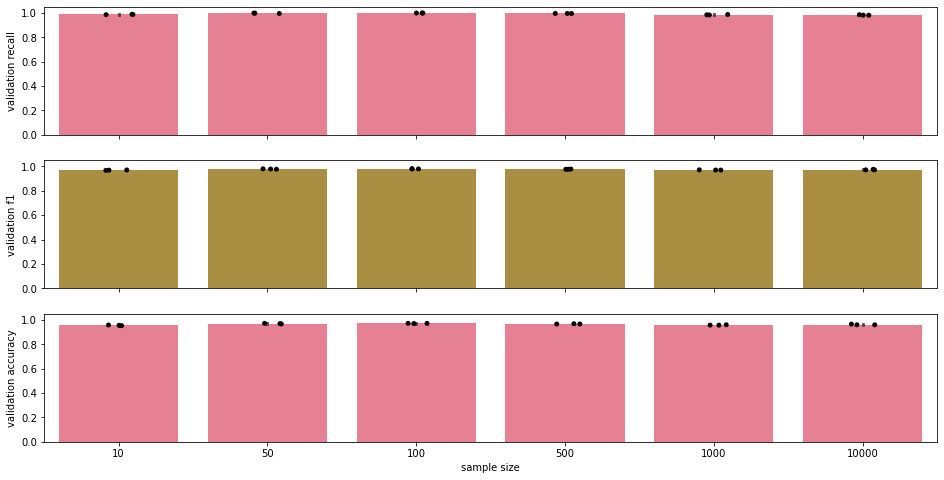

In [70]:
fig,axs=plt.subplots(3,figsize=(16,8),sharey=True,sharex=True);
[
    (sns.barplot(x='variable_0',y='value',data=cvrs_df.melt().set_index('variable_1').loc[prop],ax=axs.ravel()[num]
                 ,color=sns.color_palette('husl')[num%2]),
    sns.stripplot(x='variable_0',y='value',data=cvrs_df.melt().set_index('variable_1').loc[prop]
                  ,ax=axs.ravel()[num],color='k'),
     axs.ravel()[num].set_xlabel('sample_size')
     ,
    axs.ravel()[num].set_ylabel(prop.replace('test_','validation '))
     ,axs.ravel()[num].set_xlabel('')
    )
    for num,prop in enumerate(
    ['test_'+s for s in ('recall','f1','accuracy')])]
#Python is free and no one can stop you from doing this.
plt.xlabel('sample size')
plt.show()

It's important to be able to have fun now and again, especially if your standards for fun are apparently quite low.  In the absence of any obvious better path forward, we attempt training of a model with 100 features as a limit given to the tfidf-vectorizer.  We'll bump up the minimum document frequency allowed here as well, as we expect to be dropping such features regardless and we have plenty to burn-- it would be something to check if model quality suddenly dropped, which ends up not occurring, but otherwise the hopeful gains in performance are likely worth doing what should, in principle if all else is relatively "normal",should be essentially equivalent to what we do immediately following that step regardless. 

In [ ]:
mnb_100_pipe=imb_Pipeline(steps=[('tfidf',
                 TfidfVectorizer(lowercase=False, max_df=.9, min_df=0.05,
                                 preprocessor=identity_fxn,
                                 token_pattern=None,max_features=100,
                                 tokenizer=identity_fxn,ngram_range=(1,2))),                    
                ('sampler', RandomUnderSampler(random_state=98)),
                ('clf', MultinomialNB())])

cv_mnb_100=cross_validate(mnb_100_pipe, X_train,y_train,scoring=('recall','f1'),cv=3,verbose=100,return_estimator=True)

<a id='heading4'></a><a id='heading5'></a>
# Model Selection/Evaluation

The resulting top features for all three splits were the same across all splits, or the target class this was "white", "cant", "thats", "im", and "trump".  For the negative class, the top predictors were "though", "use", "better", "first", and "game".  These can be seen by using the display function offered in the `modelling` subpackage of the `ex_id` package, called `reg_summary_table`.  For MNB, they rely on the log conditional probablities. 

One can offer explanations for some of these features, but that plays a heavy risk of what are derisively referred to as "'just-so' stories" in evolutionary biology; we'll be attempting some rationalization regardless of our derived important features but it would be worth seeing if we can get something a bit more likely-seeming.  100 is an extremely aggressive downsizing regardless, so we'll try again but with 1000 features. 

We do the same as above, but we drop the maximum document frequency a bit to try to keep things computation-friendly and raise the number of max features.

In [ ]:
mnb_1000_pipe=imb_Pipeline(steps=[('tfidf',
                 TfidfVectorizer(lowercase=False, max_df=.8, min_df=0.05,
                                 preprocessor=identity_fxn,
                                 token_pattern=None,max_features=1000,
                                 tokenizer=identity_fxn,ngram_range=(1,2))),                    
                ('sampler', RandomUnderSampler(random_state=98)),
                ('clf', MultinomialNB())])

cv_mnb_1000=cross_validate(mnb_1000_pipe, X_train,y_train,scoring=('recall','f1'),cv=3,verbose=100,return_estimator=True)

The results are essentially the same for the positive predictions here, though the resulting predictors for the negative class become a bit more interesting: "feel","games","team","play","game".  In contrast, we see here -- and notice, admittedly retroactively, a similar but weaker pattern from above-- that the *weakest* predictors for extremism in this model are "imgur","player","index","card","relationship".  imgur being a term that likely should have been removed from our data, but the rest being tantalizingly similar to what our negative class *was* well predicted by.  Similarly, the weakest predictors for the neutral class were "altleft", "pede", "r/thedonald", "centipede", and "lenin".*  

This then stimulated investigation of a model already expected to be examined, namely Complement Naive Bayes.  This is similar to traditional Naive Bayes, but instead optimizes on negative predictors-- what gives the worst prediction for *not* being in the desired class-- along with a bit of a difference in smoothing.  Note there isn't a direct implication here that what was seen implies what was next investigated, just a bit of suggestive eyebrow wiggling. 

*"centipede" being a term, perhaps in vogue around that time, for fans of Donald Trump-- a good example both of fairly concentrated language and of how time-dependent some of these terms should be expected to be. 

In [ ]:
cnb_model=imb_Pipeline(steps=[('tfidf',
                 TfidfVectorizer(lowercase=False, max_df=.8, min_df=0.05,
                                 preprocessor=identity_fxn,
                                 token_pattern=None,max_features=1000,
                                 tokenizer=identity_fxn,ngram_range=(1,2))),                    
                ('sampler', RandomUnderSampler(random_state=98)),
                ('clf', ComplementNB())])
cnb_model.fit(X_train,y_train)

We find that our recall is still quite strong, 0.98, but that our top ten predictors for the positive class are now very respectable:  "altleft", "pede", "r/thedonald", "centipede", "lenin", "maga", "msm", "kek", "liberalism", and, presumably spurious, "here" (again, one can invent explanations but this is quite risky).  

The specific language runs the already-present risk of /r/The_Donald, by far our largest representative of the positive class, having had an outsized effect on the model as a whole and hurting our results across the board.  We investigate that by passing our test data into the model again but tracking performance on a by-subreddit basis.  To facilitate all of this, the predicted and true test data labels are provided in the `models` folder.

In [12]:
y_test, y_test_hat= joblib.load(f'models\cnm_model_test_results.joblib')
with open('models\y_labels.p','rb') as f:
    y_labels=pickle.load(f)

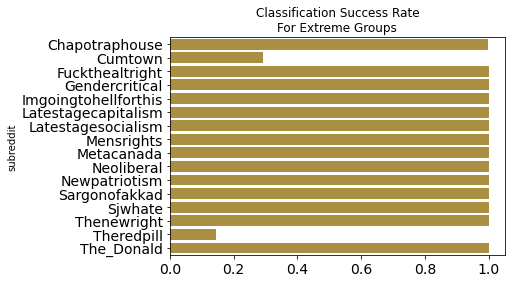

In [82]:
analyzed_test_data=pd.DataFrame({'subreddit':y_labels,'true':y_test,'predicted':y_test_hat})
pos_rec_series=analyzed_test_data[analyzed_test_data.true==1].groupby('subreddit').apply(lambda g: recall_score(g.true,g.predicted))
fig,ax=plt.subplots()
sns.barplot(y=pos_rec_series.index,x=pos_rec_series,color=sns.color_palette('husl')[1]);
ax.set_yticklabels([f.get_text().title() for f in ax.get_yticklabels()],ha='right')
plt.title('Classification Success Rate\nFor Extreme Groups')
ax.tick_params(axis='both', labelsize=14)

And we see that, in fact, we do perfectly for all strongly "far left" groups as well.  Where we do poorly are for, apologies, "cumtown" and "the_redpill" which are, respectively, subforums for a comedy podcast and a gender politics/dating strategy. So results seem promising, though the further investigations discussed in the readme are still merited.  

RandomForestClassifiers, as well as linear SVMs and logistic classifiers, were also tested.  Results were the same or inferior, with important features not being more desirable.  As such, it is recommended that Complement Naive Bayes be the model used going forward. 

<a id='heading6'></a>
# Concluding Remarks

Overlaying all considerations with respect to this model should be the relatively poor quality of the data used.  This should be viewed as a proof-of-concept work at best, with some consideration then given to how well the concept is actually proven.  There's a few sub-concerns then. 

### Considering the Metric
Recall was used here as the **quantifiable** criteria upon which we selectd our models.  As we discussed though, this was not the sole criteria used and the extremely high success rate of all models -- high enough to give reason for caution -- rendered the concern a little moot.  Why use recall as a metric though?  As is often the case, this is not decision was not made free of ambiguity.  Recalling (no pun intended) again our primary envisioned usage, what we envision is automatically profiling subforums from time to time, perhaps whenever free resources are available, and identifying those that merit closer review.  The thinking being here that, while it's not feasible for a human to personally review *every* community, it's not a particularly difficult task to do a provisional check that a community that seems potentially problematic merits closer inspection.  As such, we seek simply to ensure we're flagging for human inspection all those communities that *should* merit inspection-- hence, recall.  The downside here of course is that the vast majority of *actual* communities that are flagged will likely be false positives, but given the fuzzy topic boundaries and the envisioned use of this tool as **not** being decisive this is likely unavoidable and ultimately not too huge of an issue-- if it's clear that a given community is being mistakenly tagged as "extreme" then by definition that will be something obvious; by the same token it may be unclear if a given community *warrants action* but it can't really "falsely appear" to be extreme, to imagine a deeper phenomenon than surface charateristics here is essentially to commit a fallacy of reification.  A rose by any other name, or something similar.  

It's *somewhat* illustrative to see how our model performed on our test data with respect to truly "non-extreme" communities.  

<AxesSubplot:xlabel='predicted', ylabel='count'>

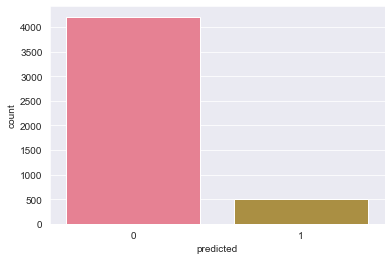

In [31]:
test_results=pd.DataFrame({'subreddit':y_labels,'true':y_test,'predicted':y_test_hat})
sns.countplot(
    test_results.loc[(test_results.true==0)].predicted)

We can see that we do in fact label most correctly -- and this is expected, as we do quite well on all metrics.  Observing just those communities mislabeled as extreme when not:

In [98]:
misclassified=test_results.loc[(test_results.true==0)&(test_results.predicted==1)].subreddit.unique()
#Get unique subreddit names that were misclassified
misclassified.resize(int(np.ceil(misclassified.shape[0]/5)),5)
#Reshape them into a grid of width that will fit nicely in a jupyter notebook
temp_df=pd.DataFrame(misclassified).applymap(lambda s: '' if s==0 else s)
temp_df.index=[s for s in temp_df.index]

temp_df.columns=[s for s in temp_df.columns]
#Relabel the filler zeros as blanks.  Hide the index and name the columns for readability. 
temp_df.style.apply(lambda row:['background: lightpink' if row.name%2 else 'background: white' for col in row],axis=1).hide_index(
).set_caption('Misclassified Subreddits')


0,1,2,3,4
STOPBEINGEVIL,ICEPOSEIDON,WORLDNEWS,NEWS,MAPPORN
THEDOTARD,PICS,POLITICS,INCELS,ADVICEANIMALS
ASKLEO,TOPMINDSOFREDDIT,TUMBLRINACTION,CONSPIRACY,HAPAS
TODAYILEARNED,EUROPE,UKPOLITICS,OLDSCHOOLCOOL,GAMERGHAZI
ASKTHEDONALD,BLUEMIDTERM2018,SLATESTARCODEX,WELLTHATSUCKS,ASKANAMERICAN
IAMVERYSMART,FORWARDSFROMGRANDMA,POLITICALHUMOR,WAYOFTHEBERN,BEER
CRINGEANARCHY,NEWZEALAND,DRAMA,KERALA,AUSTRALIA
UNDELETE,TECHNOLOGY,LASTWEEKTONIGHT,SAMHARRIS,CANADA
CONSERVATIVE,SUBREDDITDRAMA,JOEROGAN,UNCENSOREDNEWS,POLANDBALL
HILLARYCLINTON,IMPEACHTRUMP,BEHOLDTHEMASTERRACE,BESTOF,SYRIANCIVILWAR


### On Labelling

We can see that some of the mislabeled subreddits are a result of likely our biggest weakness; detecting fairly neutral political subreddits (e.g, 'politicaldiscussion').  Beyond this, we have a large number of communities that *are* mistakenly flagged but which one would expect a reasonable, not overly-sophisticated tool to fail on, namely those communities dedicated to covering "extreme" communities (e.g, "againsthatesubreddits") which presumably quote many "extreme" communities and those communities which are perhaps borderline but wouldn't themselves qualify as "extreme" (e.g, anarchocapitalism).  Mislabelling in cases like this does not represent a severe failure, as mentioned before.

Importantly, we have communities that *do* qualify for being labeled as "extreme" but were accidentally passed over-- here, for instance, "uncensorednews", a now banned community that would qualify under the initial constraints laid out as being "extreme". Its not being labelled as such simply represents corruption in the real-world data; necessarily unavoidable to some extent given resource constraints.  

Lastly, we have some communities that don't appear to be correctly classified for reasons that seem obscure (and again, we should resist the urge to speculate too strongly).  Those could be the result of transient effects, for instance we may have happened to capture a single snapshot that just happened to be especially emblematic of what we were looking for; if this is the case then repeated sampling could find it. 

The silver lining is still present in our misclassified data; we appear to be mistakenly catching subs that "veer left" just as readily as those that "veer right".

Another opportunity for further work immediately presents itself here-- engage in more aggressive labelling of subreddits as "extreme" prior to further modelling.  Iterative techniques, based on semi-learning techniques mentioned in the readme, can be used here. 

### Further Work

#### Deployment
The system, as it stands now, can be provisionally deployed as it stands.  Collecting subreddits from a feed of new posts can then be routed through a simple API call to automatically classify posts.  Depending on what things look like behind the scenes, actual deployment can likely be more sophisticated than this.  The method described here though is quite easy to implement; doing so is a little beyond the scope of the project but a simple implementation of the post-gathering system can be seen here; note by default we set out method to look in the same time window the data was claimed from but that window can be adjusted:

In [406]:
model=joblib.load('models/primary_model.joblib')

new_posts=get_new_posts('pets')
#Grabbing an arbitrary subreddit, here one dedictated to pets
print('snapshot preview for /r/pets:\n','----'*10,'\n',new_posts[:500],'\n','----'*10)
#print a preview of what we're getting
print('pets subreddit prediction:', model.predict(
    [reddittokenizer.tokenize(new_posts)
              ])
     ,'\n')
#Tokenize and predict

new_posts2=get_new_posts('uncensorednews')
#Grabbing another arbitrary subreddit, here the known extreme one mentioned above
print(new_posts2[:500])
#print a preview
print('uncensorednews prediction:',
model.predict([reddittokenizer.tokenize(new_posts2)])
)

snapshot preview for /r/pets:
 ---------------------------------------- 
 yeah it does thanks get him those really hard rubber toys also get him to stick to a sleeping schedule my big doggo sleeps almost the whole day when im out does he play at all we had a kitten and thought he was just super tired and he turned out to be really sick make sure you mention his lack of activity to the vet pricing varies a lot depending on your area that being said ive worked for vets for almost 15 years and the same treatment would have cost anywhere from 1000 to 1500 at most of the o 
 ----------------------------------------
pets subreddit prediction: [0] 

fortunately in the us we have rights that guarantee our choice to be ignorant sheep unfortunately in the us we have rights that guarantee our choice to be ignorant sheep truthfully though most other religions are in decline seems like islam is the only one that could be suppressed because the rest will slowly die out naturally and well all be bett

As always, apologies the language.  Further deployment strategies could involve routing messages to suport staff, as discussed in the readme.  As a "dry run", such a routing could merely be recorded while existing methods are still used, allowing for performance to be gauged without invoking real risks immediately.

The call to the API demonstrated above could easily be made into a small novelty app for web deployment; invoking the code above on the most recent 100 posts a given subreddit has (which will be the default method done if the time window is suppressed).  Ideally the model would first be retrained on more recently available data first, though exactly *how* recent is somewhat tricky for the reasons given when selecting this time window in the first place.

#### Improvements & Refinements
Still staying close to the original plan, the most obvious thing to do here is to improve the way the data was collected and processed.  In particular, much of the regex could be cleaned up.  URL recognition in particular is unsatisfying, and some of the transformations can likely be re-ordered to minimize information loss.  Some more clever methods are used in the regex of the `get_new_posts` method demonstrated above, which was nevertheless designed to still maintain most of the **relevant** flaws in the initial work. 

As mentioned in the remarks on labelling, expanding the number of subreddits labelled initially can help offset the distortions that the upsampling and downsampling created.  Even fairly semantics-blind methods of NLP, such as the tf-idf vectorization used here, are relatively soft to most resampling techniques and so being able to mitigate this would be highly desirable.  

A more rigorous investigation of the extensibility of this tool should be conducted.  Some "stabs" were given here, in the section immediately preceding this one, but it's still bound to the same temporal frame and relied on checking out small data points.  In particular, not done here it all, if resources allow it would be instructive to try to label "extreme" subreddits with the same criteria over the next couple of years, one month at a time, and to track how the performance metrics fall off as time from the point of training increases.